# Stack Overflow Tag Prediction

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Data Preprocessing <br>
4. Exploratory Data Analysis
5. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Summary<br>

## 1. About the dataset
1. **Title:** Quora Question Pairs. Link:https://www.kaggle.com/c/quora-question-pairs 
2. **Data:** Genuine questions from Quora.
3. **Task:** For a given pair of questions we need to predict if they are duplicate or not. 
4. **Relevant Info:** Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.<br>
<br>
5. **Data includes:** 
    * **id** - the id of a training set question pair
    * **qid1, qid2** - unique ids of each question (only available in train.csv)
    * **question1, question2** - the full text of each question
    * **is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.<br>
<br>
6. **Data Overview:** 
    * Data will be in a file Train.csv
    * Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
    * Size of Train.csv - 60MB
    * Number of rows in Train.csv = 404,290 

## 2. Real-world/Business objective and constraints

**Objective:** It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. 
<br>
<br>**Constraints:**
<br>

* The cost of a mis-classification can be very high.
* You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
* No strict latency concerns.
* Interpretability is partially important.

## 3. Data and Libraries Loading

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [3]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:03:14.595555


In [4]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:15.090403


In [6]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:06:17.642726


In [7]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [8]:
print("number of duplicate questions :", df_no_dup.cnt_dup.values.sum() - df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(df_no_dup.cnt_dup.values.sum())))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [9]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [10]:
df_no_dup["Tags"].isnull().sum()

7

In [11]:
df_no_dup[df_no_dup["Tags"].isnull()]

,Title,Body,Tags,cnt_dup
777547,Do we really need NULL?,<blockquote>\n <p><strong>Possible Duplicate:...,None,1
962680,Find all values that are not null and not in a...,<p>I am running into a problem which results i...,None,1
1126558,Handle NullObjects,<p>I have done quite a bit of research on best...,None,1
1256102,How do Germans call null,"<p>In german null means 0, so how do they call...",None,1
2430668,Page cannot be null. Please ensure that this o...,<p>I get this error when i remove dynamically ...,None,1
3329908,"What is the difference between NULL and ""0""?","<p>What is the difference from NULL and ""0""?</...",None,1
3551595,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<block...,None,2


In [12]:
df_no_dup.shape

(4206315, 4)

In [13]:
df_no_dup = df_no_dup.dropna(axis = 0)

In [14]:
df_no_dup.shape

(4206308, 4)

In [15]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda x: len(x.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:02.045452


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [16]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: tag_count, dtype: int64

In [17]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [18]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:01:24.920718


In [19]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [20]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206307
Number of unique tags : 42048


In [21]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [22]:
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [23]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [24]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

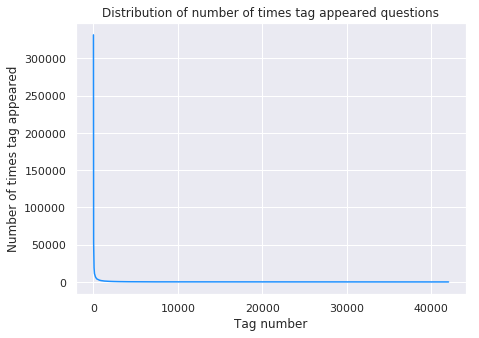

In [25]:
sns.set()
plt.figure(figsize = (7, 5))
plt.plot(tag_counts, color = 'dodgerblue')
plt.title("Distribution of number of times tag appeared questions")
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

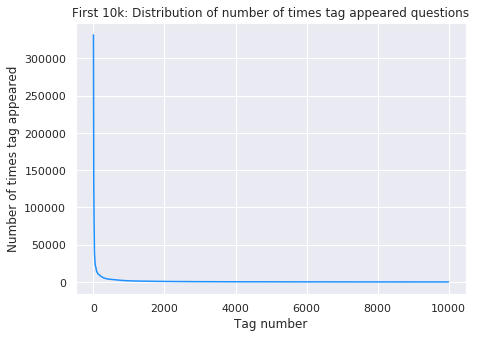

In [26]:
sns.set()
plt.figure(figsize = (7, 5))
plt.plot(tag_counts[:10000], color = 'dodgerblue')
plt.title("First 10k: Distribution of number of times tag appeared questions")
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

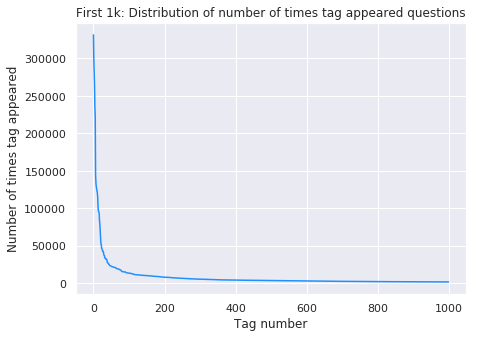

In [27]:
sns.set()
plt.figure(figsize = (7, 5))
plt.plot(tag_counts[:1000], color = 'dodgerblue')
plt.title("First 1k: Distribution of number of times tag appeared questions")
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

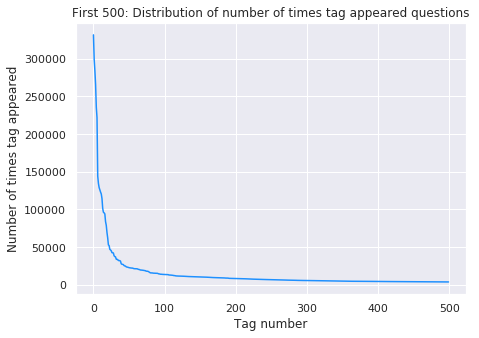

In [28]:
sns.set()
plt.figure(figsize = (7, 5))
plt.plot(tag_counts[:500], color = 'dodgerblue')
plt.title("First 500: Distribution of number of times tag appeared questions")
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

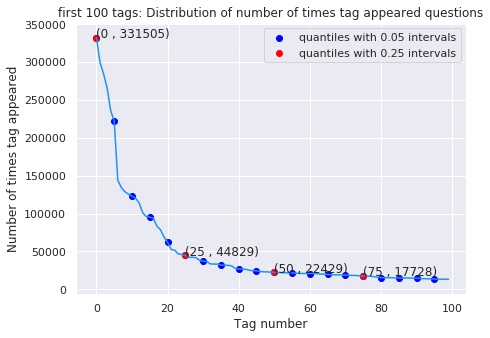

In [29]:
sns.set()
plt.figure(figsize = (7, 5))
plt.plot(tag_counts[0:100], c = 'dodgerblue')
plt.scatter(x = list(range(0,100,5)), y = tag_counts[0:100:5], c = 'blue', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x = list(range(0,100,25)), y = tag_counts[0:100:25], c = 'red', label = "quantiles with 0.25 intervals")

for x, y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

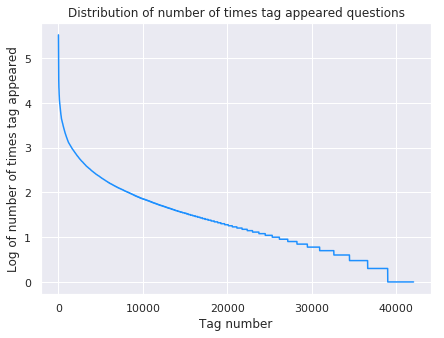

In [30]:
sns.set()
plt.figure(figsize = (7, 5))
plt.plot(np.log10(tag_counts), color = 'dodgerblue')
plt.title("Distribution of number of times tag appeared questions")
plt.xlabel("Tag number")
plt.ylabel("Log of number of times tag appeared")
plt.show()

In [31]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts > 10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts > 100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


In [32]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis = 1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206307 datapoints.
[3, 4, 2, 2, 3]


In [33]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443


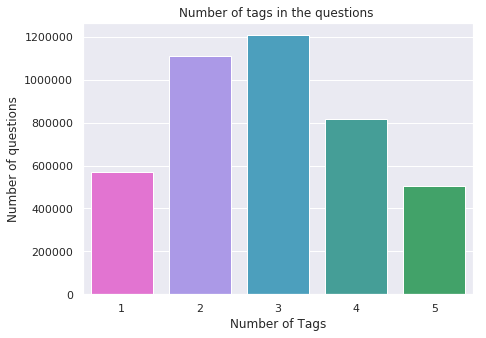

In [87]:
plt.figure(figsize = (7, 5))
sns.set_palette(reversed(sns.color_palette("husl", 8)), 8)
sns.countplot(tag_quest_count)
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

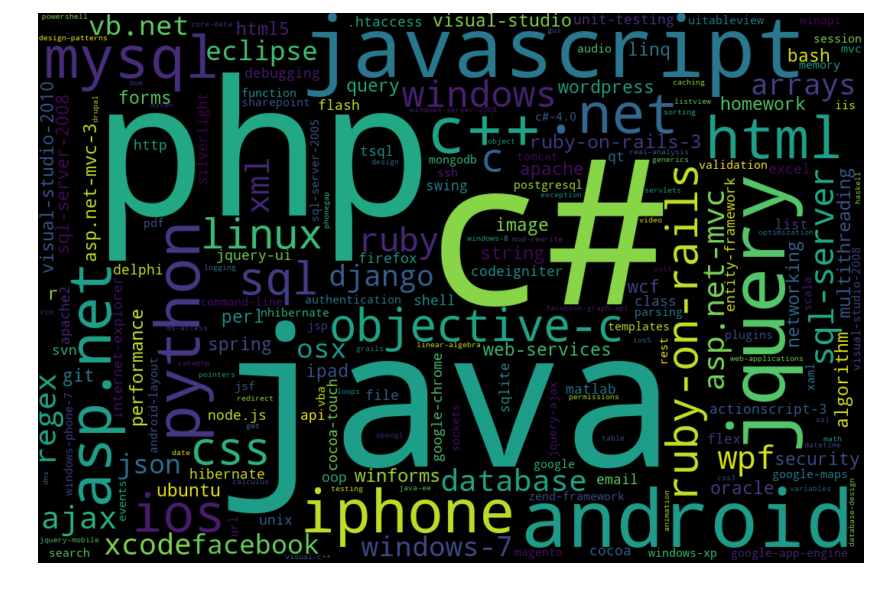

In [91]:
# Ploting word cloud
# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color = 'black',
                      width = 1080,
                      height = 720,
                     ).generate_from_frequencies(tup)

fig = plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
fig.savefig("tag.png")
plt.show()

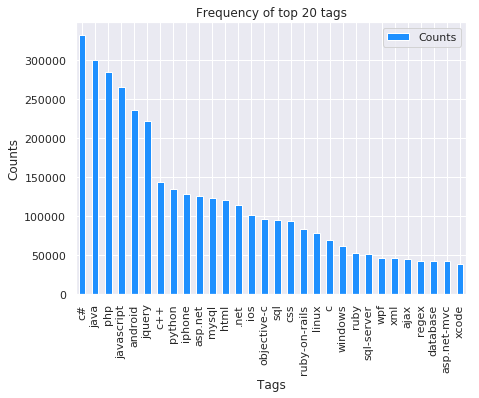

In [94]:
i = np.arange(30)
tag_df_sorted.head(30).plot(kind = 'bar', figsize = (7, 5), color = 'dodgerblue')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [2]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [6]:
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [7]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:11:12.952712


In [8]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [9]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

In [3]:
#Taking 0.5 Million entries to a dataframe.

write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [4]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [5]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


In [6]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [7]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [8]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

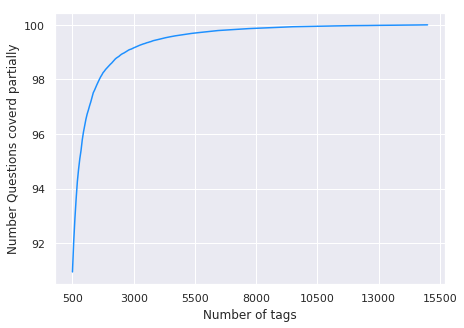

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [21]:
sns.set()
fig, ax = plt.subplots()
ax.figure.set_size_inches(7, 5)
ax.plot(questions_explained, color = 'dodgerblue')
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)

plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [9]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [10]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 29587
number of tags taken : 500 ( 1.6899313887856153 %)


In [11]:
x_train=preprocessed_data.head(400000)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:400000,:]
y_test = multilabel_yx[400000:preprocessed_data.shape[0],:]

In [12]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


In [21]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:09.243222


In [26]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (799997, 88193) Y : (799997, 5500)
Dimensions of test data X: (200000, 88193) Y: (200000, 5500)


In [26]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23659
Hamming loss  0.00278038
Micro-average quality numbers
Precision: 0.7215, Recall: 0.3260, F1-measure: 0.4491
Macro-average quality numbers
Precision: 0.5467, Recall: 0.2570, F1-measure: 0.3335
             precision    recall  f1-score   support

          0       0.94      0.64      0.76      5519
          1       0.69      0.26      0.38      8190
          2       0.81      0.37      0.51      6529
          3       0.81      0.43      0.56      3231
          4       0.81      0.41      0.54      6430
          5       0.81      0.34      0.48      2879
          6       0.87      0.50      0.63      5086
          7       0.88      0.54      0.67      4533
          8       0.60      0.13      0.22      3000
          9       0.81      0.52      0.64      2765
         10       0.59      0.16      0.26      3051
         11       0.70      0.34      0.45      3009
         12       0.65      0.24      0.35      2630
         13       0.71      0.23      0.34   

In [28]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

['lr_with_more_title_weight.pkl']

In [23]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1', n_jobs = -1), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.24714
Hamming loss  0.00269752
Micro-average quality numbers
Precision: 0.8067, Recall: 0.2946, F1-measure: 0.4316
Macro-average quality numbers
Precision: 0.4244, Recall: 0.2180, F1-measure: 0.2643
             precision    recall  f1-score   support

          0       0.95      0.67      0.79      5519
          1       0.70      0.22      0.34      8190
          2       0.84      0.36      0.50      6529
          3       0.82      0.42      0.55      3231
          4       0.85      0.37      0.52      6430
          5       0.82      0.35      0.49      2879
          6       0.88      0.51      0.65      5086
          7       0.89      0.54      0.67      4533
          8       0.62      0.14      0.23      3000
          9       0.83      0.51      0.63      2765
         10       0.66      0.01      0.02      3051
         11       0.77      0.31      0.44      3009
         12       0.74      0.22      0.34      2630
         13       0.72      0.18      0.29   

In [29]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1', n_jobs = -1), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.25109
Hamming loss  0.00270298
Micro-average quality numbers
Precision: 0.7172, Recall: 0.3673, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5569, Recall: 0.2950, F1-measure: 0.3710
             precision    recall  f1-score   support

          0       0.94      0.72      0.82      5519
          1       0.70      0.34      0.45      8190
          2       0.80      0.42      0.55      6529
          3       0.82      0.49      0.61      3231
          4       0.80      0.44      0.57      6430
          5       0.82      0.38      0.52      2879
          6       0.86      0.53      0.66      5086
          7       0.87      0.58      0.70      4533
          8       0.60      0.13      0.22      3000
          9       0.82      0.57      0.67      2765
         10       0.60      0.20      0.30      3051
         11       0.68      0.38      0.49      3009
         12       0.62      0.29      0.40      2630
         13       0.73      0.30      0.43   

In [13]:
start = datetime.now()
vectorizer = CountVectorizer(max_features=100000,
                             tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:12.532089


In [17]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 200000) Y : (400000, 500)
Dimensions of test data X: (100000, 200000) Y: (100000, 500)


In [20]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.11197
Hamming loss  0.00587496
Micro-average quality numbers
Precision: 0.2911, Recall: 0.4808, F1-measure: 0.3627
Macro-average quality numbers
Precision: 0.2117, Recall: 0.4097, F1-measure: 0.2710
             precision    recall  f1-score   support

          0       0.74      0.80      0.77      5519
          1       0.45      0.44      0.44      8190
          2       0.52      0.52      0.52      6529
          3       0.51      0.59      0.55      3231
          4       0.53      0.56      0.55      6430
          5       0.41      0.50      0.45      2879
          6       0.58      0.64      0.61      5086
          7       0.60      0.67      0.63      4533
          8       0.22      0.21      0.21      3000
          9       0.55      0.63      0.59      2765
         10       0.31      0.36      0.33      3051
         11       0.44      0.54      0.48      3009
         12       0.38      0.46      0.42      2630
         13       0.36      0.44      0.40   

In [ ]:
# applying grid search to find best c 
from sklearn.model_selection import GridSearchCV  
tuned_parameters = [{'estimator__C': [0.01, 0.1, 1.0, 10, 100]}]
    
model = GridSearchCV(OneVsRestClassifier(LogisticRegression(penalty='l1', multi_class = 'ovr')), tuned_parameters, scoring = 'f1_micro', cv=2, n_jobs = -1)
model.fit(x_train_multilabel, y_train)

print(model.best_estimator_)

In [21]:
y_train.shape

(400000, 500)

In [22]:
x_train_multilabel.shape

(400000, 200000)